In [2]:
import numpy as np
from OpenEphys import loadContinuous
import os
import glob
from scipy import signal as ss
from scipy import stats as st
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Select file for analysis
files_to_be_converted = ['401a_2018-04-18_16-34-20_NO_CNO']
source_folder = r'D:\SERT_DREADD\good_eegchans'

path = "/".join([source_folder,files_to_be_converted[0]])
os.chdir(path)
file = glob.glob("*.continuous")
print(file[0])
eegdata = loadContinuous(file[0], dtype=float)
array = eegdata['data']

#Resampling the data
duration = np.shape(array)[0]/30000
newarrayshape = np.real(int(round(250*duration)))
newarray=ss.resample(array, newarrayshape)

#Functions for filters
def butter_lowpass(low_cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_low_cutoff = low_cutoff / nyq
    b_low, a_low = butter(order, normal_low_cutoff, btype='lowpass', analog=False)
    return b_low, a_low

def butter_lowpass_filter(data, low_cutoff, fs, order=5):
    b_low, a_low = butter_lowpass(low_cutoff, fs, order=order)
    y_low = lfilter(b_low, a_low, data)
    return y_low

# Filter requirements.
order = 5
fs = 30000.0       # sample rate, Hz
low_cutoff = 100 # desired cutoff frequency of the filter, Hz
high_cutoff = 0.1


# Filter the data.
print('Filtering data')
filtered_array = butter_lowpass_filter(newarray, low_cutoff, fs, order)


#Spectrogram
sampling_rate = 250
bin_size = sampling_rate * 4

100_CH43.continuous
Loading continuous data...
Filtering data


In [4]:
freqs, Sxx = ss.welch(x=filtered_array,
                     fs=sampling_rate,
                    window=ss.get_window('hamming', bin_size),
                     noverlap=bin_size/2,
                     nperseg=bin_size)

In [5]:
Sxx.shape

(501,)

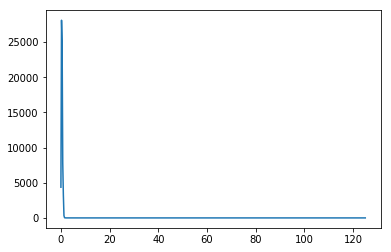

In [6]:
plt.plot(freqs, Sxx)